
# A bike-sharing system case study

### Problem Statement 

A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic.The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state.

### Business Objective

The company has gathered a large dataset on daily bike demands across the American market based on some factors. It wants to understand the factors on which the demand for these shared bikes depends. Essentially, it wants to know:

-Which variables are significant in predicting the demand for shared bikes.

-How well those variables describe the bike demands. 

-To identify the variables affecting bike count, e.g season, yr,month,holiday etc.

-To create a linear model that quantitatively relates bike counts(total rental bikes) 

-To know the accuracy of the model, i.e. how well these variables can predict bike counts.

They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations.

So interpretation is important!

In [73]:
#import the libraries
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sb
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm  
from statsmodels.stats.outliers_influence import variance_inflation_factor



# Data Visualisation

In [74]:
#read the dataset and check the first five rows
bk = pd.read_csv("day.csv")
bk.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [75]:
#Check the shape of the dataframe
bk.shape


(730, 16)

# Data Handling and Cleaning

In [76]:
#Check the datatypes of all the columns of the dataframe
bk.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [77]:
# Check for empty rows and columns
print(bk.isnull().all(axis=1).sum())
print(bk.isnull().all(axis=0).sum())

0
0


The rows and columns of the dataframe doesnot contain any missing values.

In [78]:
# Check if there are any duplicate values in the dataset
bk[bk.duplicated(keep=False)]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


In [79]:
# Columns having single value?
bk.columns[bk.nunique() == 1]

Index([], dtype='object')

Columns those are irrelevant for our analysis are:

>- "instant"  : Since it only contain the record index.
>- "casual","registered": Since cnt is present which is count of total rental bikes including both casual and registered.
>- "dteday" :As already we have month,weekday,year columns so dteday is not required for our analysis.


In [80]:
# Drop the irrelevant columns identified
irrelevant_columns = ['instant','casual','registered','dteday']
bk.drop(irrelevant_columns, axis=1, inplace=True)

In [81]:
bk.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [82]:
#Mapping variables season, month, weathersit, weekday
#Since these features are nominal variables so ordering is not important.
bk['season']=bk.season.map({1: 'spring', 2: 'summer',3:'fall', 4:'winter' })
bk['mnth']=bk.mnth.map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
bk['weathersit']=bk.weathersit.map({1: 'Clear',2:'Mist + Cloudy',3:'Light Snow',4:'Snow + Fog'})
bk['weekday']=bk.weekday.map({0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'})

bk.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,Jan,0,Sat,0,Mist + Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,Jan,0,Sun,0,Mist + Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,Jan,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


# Visualising the Data

Visualising Numeric Variables Let's make a pairplot of all the numeric variables.

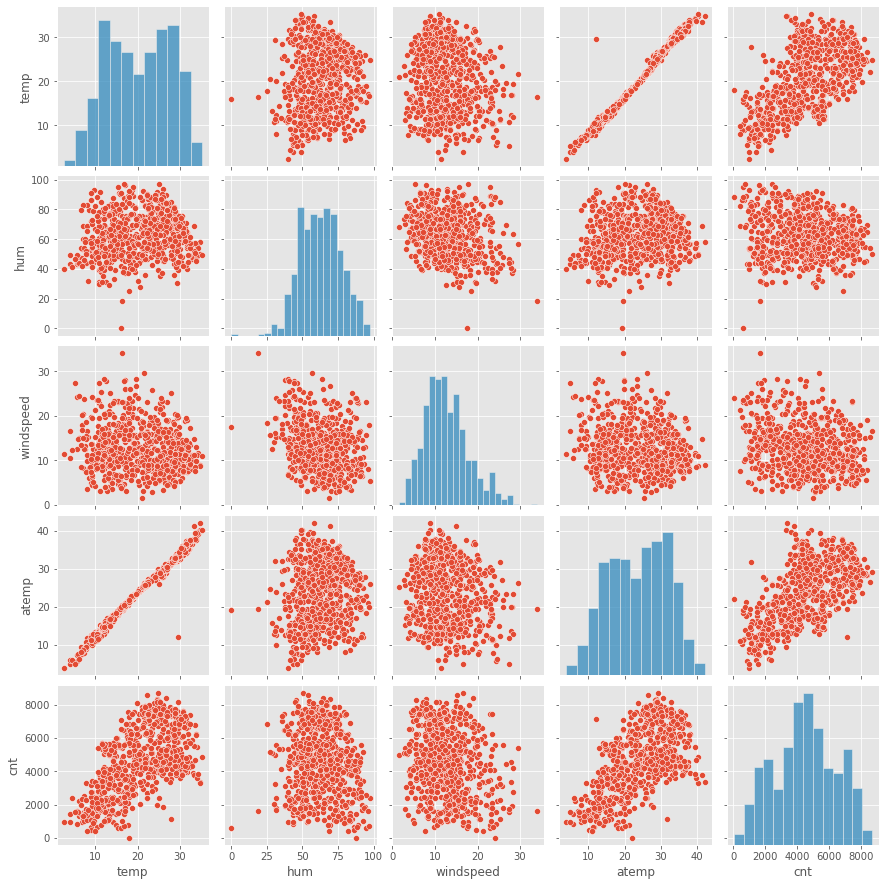

In [83]:
sns.pairplot(bk,vars=["temp", "hum",'windspeed','atemp','cnt'])
plt.show()

From the above figures there are some independent variables look positively correlated to the 'cnt' variable.

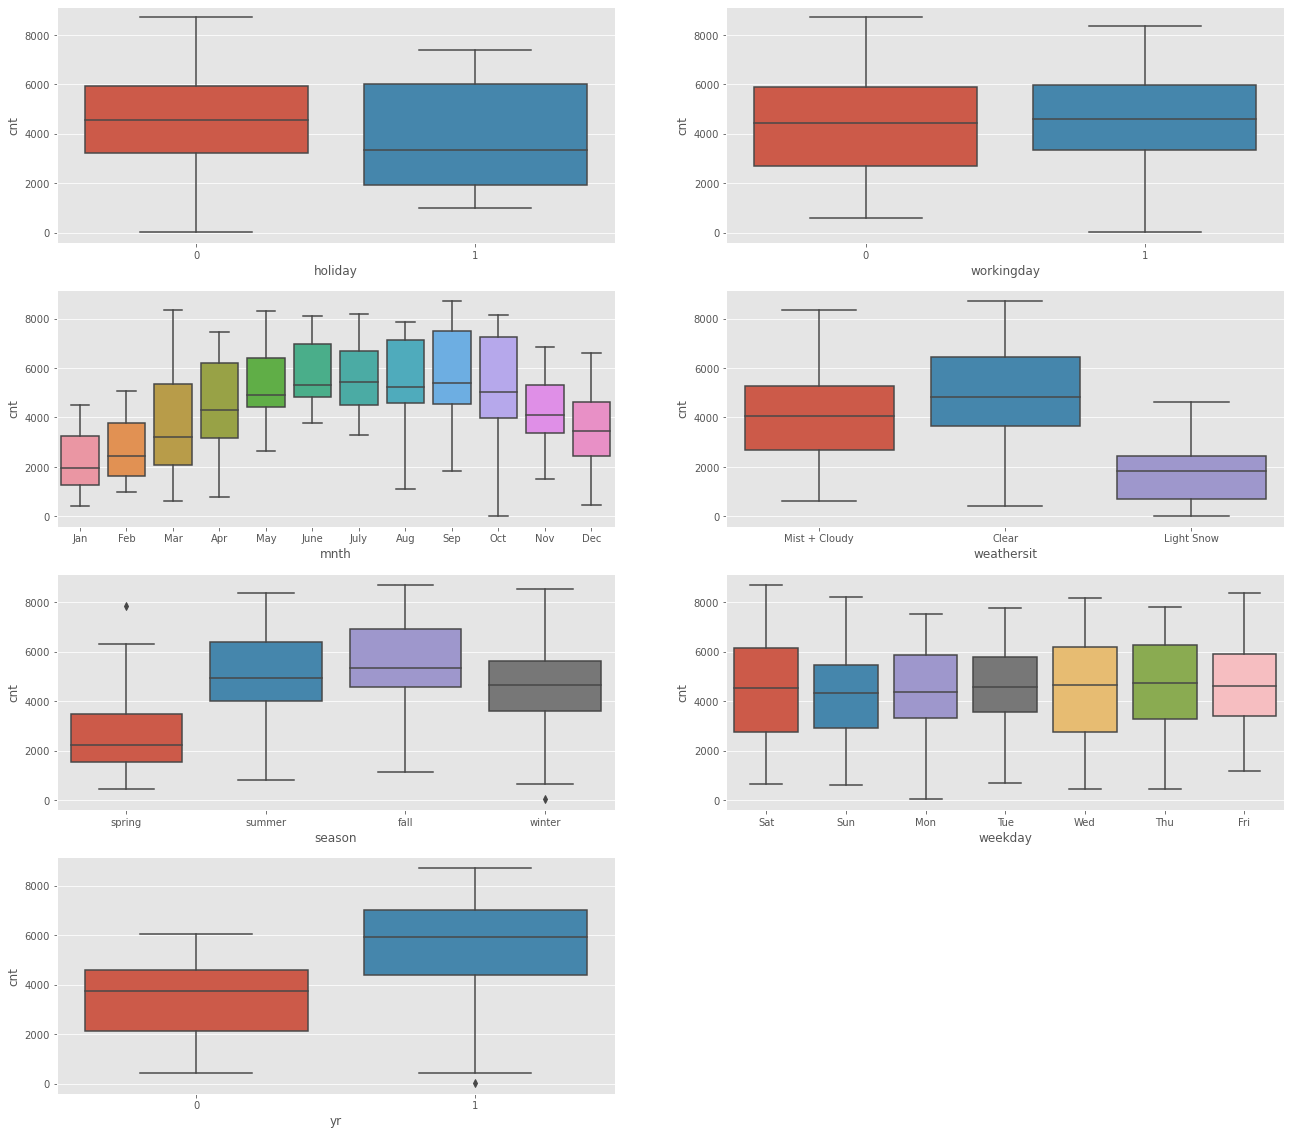

In [84]:
#Visualising Categorical Variables There are a few categorical variables are present so let's make a boxplot.

plt.figure(figsize=(22, 20))

plt.subplot(4,2,1)
sns.boxplot(x = 'holiday', y = 'cnt', data = bk)

plt.subplot(4,2,2)
sns.boxplot(x = 'workingday', y = 'cnt', data = bk)

plt.subplot(4,2,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = bk)

plt.subplot(4,2,4)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bk)

plt.subplot(4,2,5)
sns.boxplot(x = 'season', y = 'cnt', data = bk)

plt.subplot(4,2,6)
sns.boxplot(x = 'weekday', y = 'cnt', data = bk)

plt.subplot(4,2,7)
sns.boxplot(x = 'yr', y = 'cnt', data = bk)

plt.show()

##### Observations:

    Demand of bike is more if it is not a holiday.
    
    Demand of bikes is more in month of September.
    
    In clear weathersit bikes demands are more compared to mist cloudy.
    
    In fall season demand of bike is more.
    
    In year 2019 demand of bike increases as compared to 2018.
    

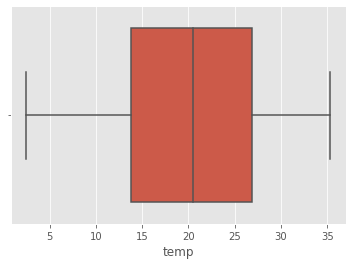

In [85]:
#Create a box plot for the temp column
sns.boxplot(bk.temp)
plt.show()

The median of temprature lies in 20.

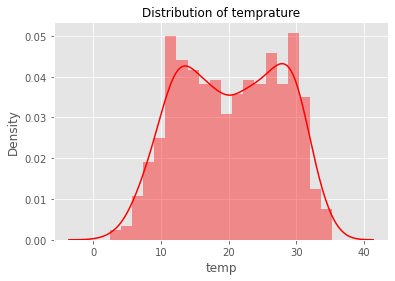

In [86]:
plt.style.use('ggplot')
sns.distplot(bk.temp,bins = 20, color = 'r')
plt.title('Distribution of temprature', fontsize = 12)
plt.show()


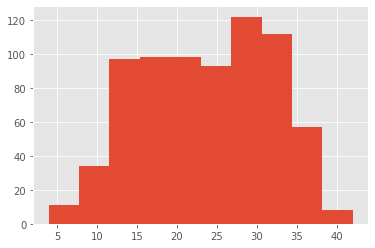

In [87]:
#Plot a histogram for Size as well.
plt.hist(bk.atemp)
plt.show()

atemp is high around 27-32.

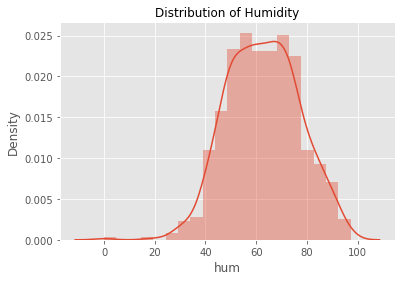

In [88]:
sns.distplot(bk.hum,bins = 20)
plt.title('Distribution of Humidity', fontsize = 12)
plt.show()

The humiditiy is high at 40-60.

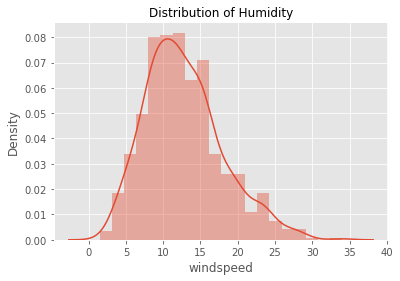

In [89]:
# wind speed
sns.distplot(bk.windspeed,bins = 20)
plt.title('Distribution of Humidity', fontsize = 12)
plt.show()

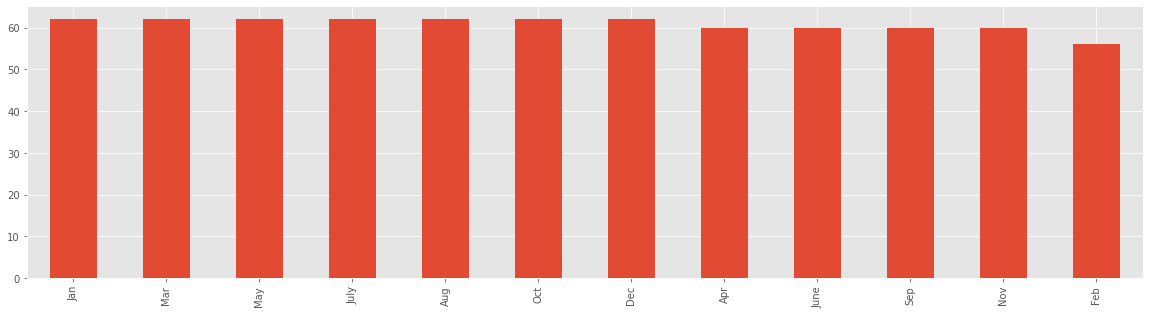

In [90]:
plt.style.use('ggplot')
plt.figure(figsize=(20,5))
bk['mnth'].value_counts().plot.bar()
plt.show()

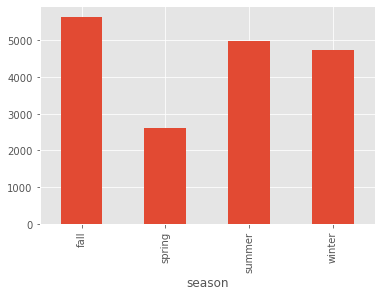

In [91]:
##Plot a bar plot of Content Rating vs Average Rating 
bk.groupby(['season'])['cnt'].mean().plot.bar()
plt.show()


Fall season has more bike demands followed by summer followed by winter.In Spring bike demands are less.

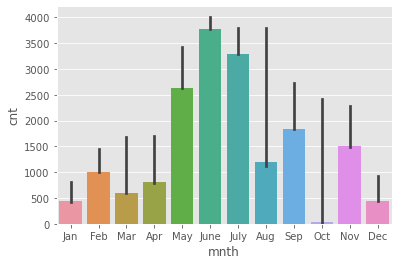

In [92]:
##Plot the bar plot
sns.barplot(data=bk,x='mnth',y='cnt',estimator=lambda x : np.percentile(x,0.05))
plt.show()


At the lower percentile demand of bike is more in june month.

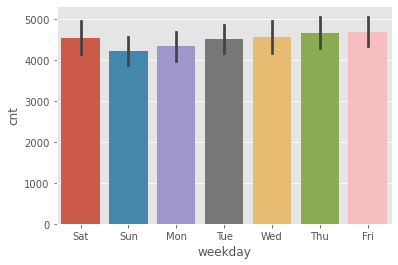

In [93]:
##Plot the bar plot with only the 5th percentile of Ratings
sns.barplot(data=bk,x='weekday',y='cnt',estimator=np.mean)
plt.show()

In weekdays there is no much difference in demand of bikes.

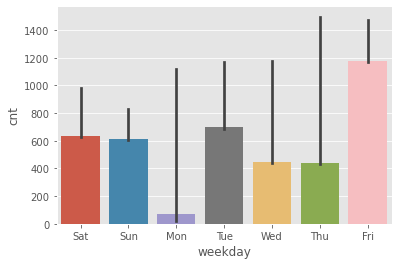

In [94]:
##Plot the bar plot with only the 5th percentile of cnt
sns.barplot(data=bk,x='weekday',y='cnt',estimator=lambda x : np.percentile(x,0.05))
plt.show()

Friday the demand is more when we consider the lower percentile.

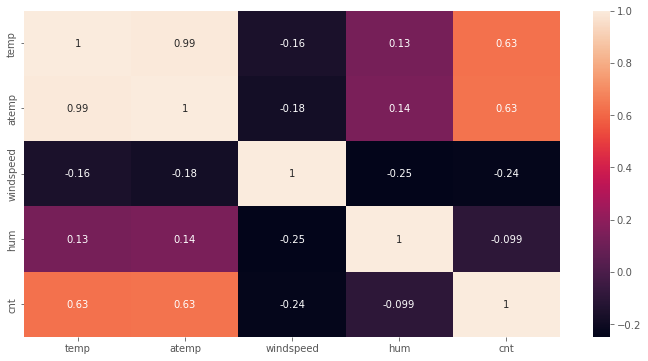

In [95]:
plt.figure(figsize = (12,6))
sns.heatmap(bk[["temp",'atemp', 'windspeed','hum','cnt']].corr(),annot =True)
plt.show()

clearly from the above correlation matix the temp and atemp are highly correlated.
So we have to drop either one of them.

In [96]:
#Dropping of atemp 
bk = bk.drop(['atemp'],axis=1)

<AxesSubplot:>

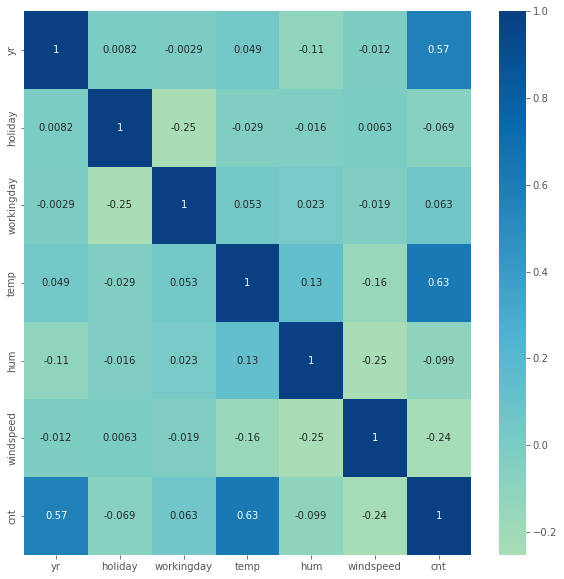

In [97]:
# correlation among variables
plt.figure(figsize=[10,10])
sns.heatmap(bk.corr(),cmap='GnBu',center=0,annot=True)

# Data Preparation

Since our data set has many string values, in order to fit a regression line, we would need numerical values and not string. Hence, we need to convert them .

In [98]:
## Dummy variables for month, season, weathersit, weekday and temp_bucket

mnths=pd.get_dummies(bk.mnth,drop_first=True)
weekdays=pd.get_dummies(bk.weekday,drop_first=True)
weather_sit=pd.get_dummies(bk.weathersit,drop_first=True)
seasons=pd.get_dummies(bk.season,drop_first=True)


In [99]:
#Add the results to the original bike dataframe

bk = pd.concat([mnths,weekdays,weather_sit,seasons,bk],axis=1)
bk.head()

,Aug,Dec,Feb,Jan,July,June,Mar,May,Nov,Oct,...,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,0,0,0,1,0,0,0,0,0,0,...,0,Jan,0,Sat,0,Mist + Cloudy,14.110847,80.5833,10.749882,985
1,0,0,0,1,0,0,0,0,0,0,...,0,Jan,0,Sun,0,Mist + Cloudy,14.902598,69.6087,16.652113,801
2,0,0,0,1,0,0,0,0,0,0,...,0,Jan,0,Mon,1,Clear,8.050924,43.7273,16.636703,1349
3,0,0,0,1,0,0,0,0,0,0,...,0,Jan,0,Tue,1,Clear,8.200000,59.0435,10.739832,1562
4,0,0,0,1,0,0,0,0,0,0,...,0,Jan,0,Wed,1,Clear,9.305237,43.6957,12.522300,1600


In [100]:
# Drop 'season','mnth','weekday','weathersit' from bike dataset

bk.drop(['season','mnth','weekday','weathersit'], axis = 1, inplace = True)
bk.head()


,Aug,Dec,Feb,Jan,July,June,Mar,May,Nov,Oct,...,spring,summer,winter,yr,holiday,workingday,temp,hum,windspeed,cnt
0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,14.110847,80.5833,10.749882,985
1,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,14.902598,69.6087,16.652113,801
2,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,8.050924,43.7273,16.636703,1349
3,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,8.200000,59.0435,10.739832,1562
4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,9.305237,43.6957,12.522300,1600


In [101]:
bk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Aug            730 non-null    uint8  
 1   Dec            730 non-null    uint8  
 2   Feb            730 non-null    uint8  
 3   Jan            730 non-null    uint8  
 4   July           730 non-null    uint8  
 5   June           730 non-null    uint8  
 6   Mar            730 non-null    uint8  
 7   May            730 non-null    uint8  
 8   Nov            730 non-null    uint8  
 9   Oct            730 non-null    uint8  
 10  Sep            730 non-null    uint8  
 11  Mon            730 non-null    uint8  
 12  Sat            730 non-null    uint8  
 13  Sun            730 non-null    uint8  
 14  Thu            730 non-null    uint8  
 15  Tue            730 non-null    uint8  
 16  Wed            730 non-null    uint8  
 17  Light Snow     730 non-null    uint8  
 18  Mist + Clo

In [102]:
bk.shape

(730, 29)

# Splitting the Data into Training and Testing Sets

In [103]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
bk_train, bk_test = train_test_split(bk, train_size = 0.7, test_size = 0.3, random_state = 100)

In [104]:
print(bk_train.shape)
print(bk_test.shape)

(510, 29)
(219, 29)


Rescaling the Features It is important to have all the variables on the same scale for the model to be easily interpretable. We can use standardization or normalization so that the units of the coefficients obtained are all on the same scale. There are two common ways of rescaling:

Min-Max scaling Standardisation (mean-0, sigma-1)

This time, we will use MinMax scaling.

In [105]:
scaler = MinMaxScaler()

In [106]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['hum','windspeed','temp','cnt']

bk_train[num_vars] = scaler.fit_transform(bk_train[num_vars])

In [107]:
bk_train.head()

,Aug,Dec,Feb,Jan,July,June,Mar,May,Nov,Oct,...,spring,summer,winter,yr,holiday,workingday,temp,hum,windspeed,cnt
653,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,1,0.509887,0.575354,0.300794,0.864243
576,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0.815169,0.725633,0.264686,0.827658
426,0,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0.442393,0.640189,0.255342,0.465255
728,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0.245101,0.498067,0.663106,0.204096
482,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0.395666,0.504508,0.188475,0.482973


In [108]:
bk_train.describe()

,Aug,Dec,Feb,Jan,July,June,Mar,May,Nov,Oct,...,spring,summer,winter,yr,holiday,workingday,temp,hum,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.00000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.096078,0.084314,0.066667,0.088235,0.076471,0.074510,0.098039,0.084314,0.086275,0.086275,...,0.243137,0.245098,0.24902,0.507843,0.025490,0.676471,0.537262,0.650369,0.320768,0.513620
std,0.294988,0.278131,0.249689,0.283915,0.266010,0.262857,0.297660,0.278131,0.281045,0.281045,...,0.429398,0.430568,0.43287,0.500429,0.157763,0.468282,0.225844,0.145882,0.169797,0.224593
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.339853,0.538643,0.199179,0.356420
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,0.540519,0.653714,0.296763,0.518638
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,0.735215,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


All the numeric variables are now mapped between 0 and 1

### Dividing into X and Y sets for the model building

In [109]:
y_train = bk_train.pop('cnt')
X_train = bk_train



In [110]:
X_train.head()

,Aug,Dec,Feb,Jan,July,June,Mar,May,Nov,Oct,...,Mist + Cloudy,spring,summer,winter,yr,holiday,workingday,temp,hum,windspeed
653,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,1,0.509887,0.575354,0.300794
576,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0.815169,0.725633,0.264686
426,0,0,0,0,0,0,1,0,0,0,...,1,1,0,0,1,0,0,0.442393,0.640189,0.255342
728,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0.245101,0.498067,0.663106
482,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0.395666,0.504508,0.188475


Building our model

We will be using the LinearRegression function from SciKit Learn for its compatibility with RFE (which is a utility from sklearn)

RFE Recursive feature elimination

In [111]:
# Running RFE with selecting 12 variables 
lm = LinearRegression()
lm.fit(X_train, y_train)

np.random.seed(0)
rfe = RFE(lm,n_features_to_select=10)             # running RFE,10 is the number of variables we want RFE to select
rfe = rfe.fit(X_train, y_train)

In [112]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Aug', False, 11),
 ('Dec', False, 8),
 ('Feb', False, 9),
 ('Jan', False, 6),
 ('July', True, 1),
 ('June', False, 19),
 ('Mar', False, 18),
 ('May', False, 10),
 ('Nov', False, 7),
 ('Oct', False, 13),
 ('Sep', True, 1),
 ('Mon', False, 14),
 ('Sat', False, 4),
 ('Sun', False, 12),
 ('Thu', False, 17),
 ('Tue', False, 15),
 ('Wed', False, 16),
 ('Light Snow', True, 1),
 ('Mist + Cloudy', False, 2),
 ('spring', True, 1),
 ('summer', False, 3),
 ('winter', True, 1),
 ('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 5),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1)]

In [113]:
# Looking at the cols that RFE selected
col = X_train.columns[rfe.support_]
col

Index(['July', 'Sep', 'Light Snow', 'spring', 'winter', 'yr', 'holiday',
       'temp', 'hum', 'windspeed'],
      dtype='object')

In [114]:
# Looking at the cols that RFE not selected
X_train.columns[~rfe.support_]

Index(['Aug', 'Dec', 'Feb', 'Jan', 'June', 'Mar', 'May', 'Nov', 'Oct', 'Mon',
       'Sat', 'Sun', 'Thu', 'Tue', 'Wed', 'Mist + Cloudy', 'summer',
       'workingday'],
      dtype='object')

Building model using statsmodel, for the detailed statistics

In [115]:
# Creating X_train_rfe dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [116]:
# Adding a constant variable 
#import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

In [117]:
# Running the linear model
lm = sm.OLS(y_train,X_train_rfe).fit() 

# Model - 1

In [118]:
#Looking at the summary of our linear model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     242.9
Date:                Mon, 10 Oct 2022   Prob (F-statistic):          1.53e-184
Time:                        17:03:01   Log-Likelihood:                 489.69
No. Observations:                 510   AIC:                            -957.4
Df Residuals:                     499   BIC:                            -910.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3769      0.031     12.133      0.000       0.316       0.438
July          -0.0805      0.018     -4.538      0.000      -0.115      -0.046
Sep            0.0598      0.016      3.723      0.000       0.028       0.091
Light Snow    -0.1980      0.026     -7.659      0.000      -0.249      -0.147
spring        -0.1005      0.015     -6.536      0.000      -0.131      -0.070
winter         0.0653      0.013      5.153      0.000       0.040       0.090
yr             0.2281      0.008     27.102      0.000       0.212       0.245
holiday       -0.0920      0.026     -3.472      0.001      -0.144      -0.040
temp           0.5147      0.031     16.542      0.000       0.454       0.576
hum           -0.2728      0.032     -8.542      0.000      -0.336      -0.210
windspeed     -0.1887      0.026     -7.194      0.000      -0.240      -0.137
==============================================================================
Omnibus:                       51.023   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.492
Skew:                          -0.593   Prob(JB):                     1.51e-22
Kurtosis:                       4.823   Cond. No.                         16.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P- values of all the variables are significant as it is less then 0.05.So let us check for VIF.

VIF (Variable Inflation Factor) Calculation

In [119]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,56.13
8,temp,2.87
4,spring,2.53
5,winter,1.75
1,July,1.29
9,hum,1.26
10,windspeed,1.15
2,Sep,1.11
3,Light Snow,1.11
6,yr,1.03


VIF of all the variables are less than 3. 

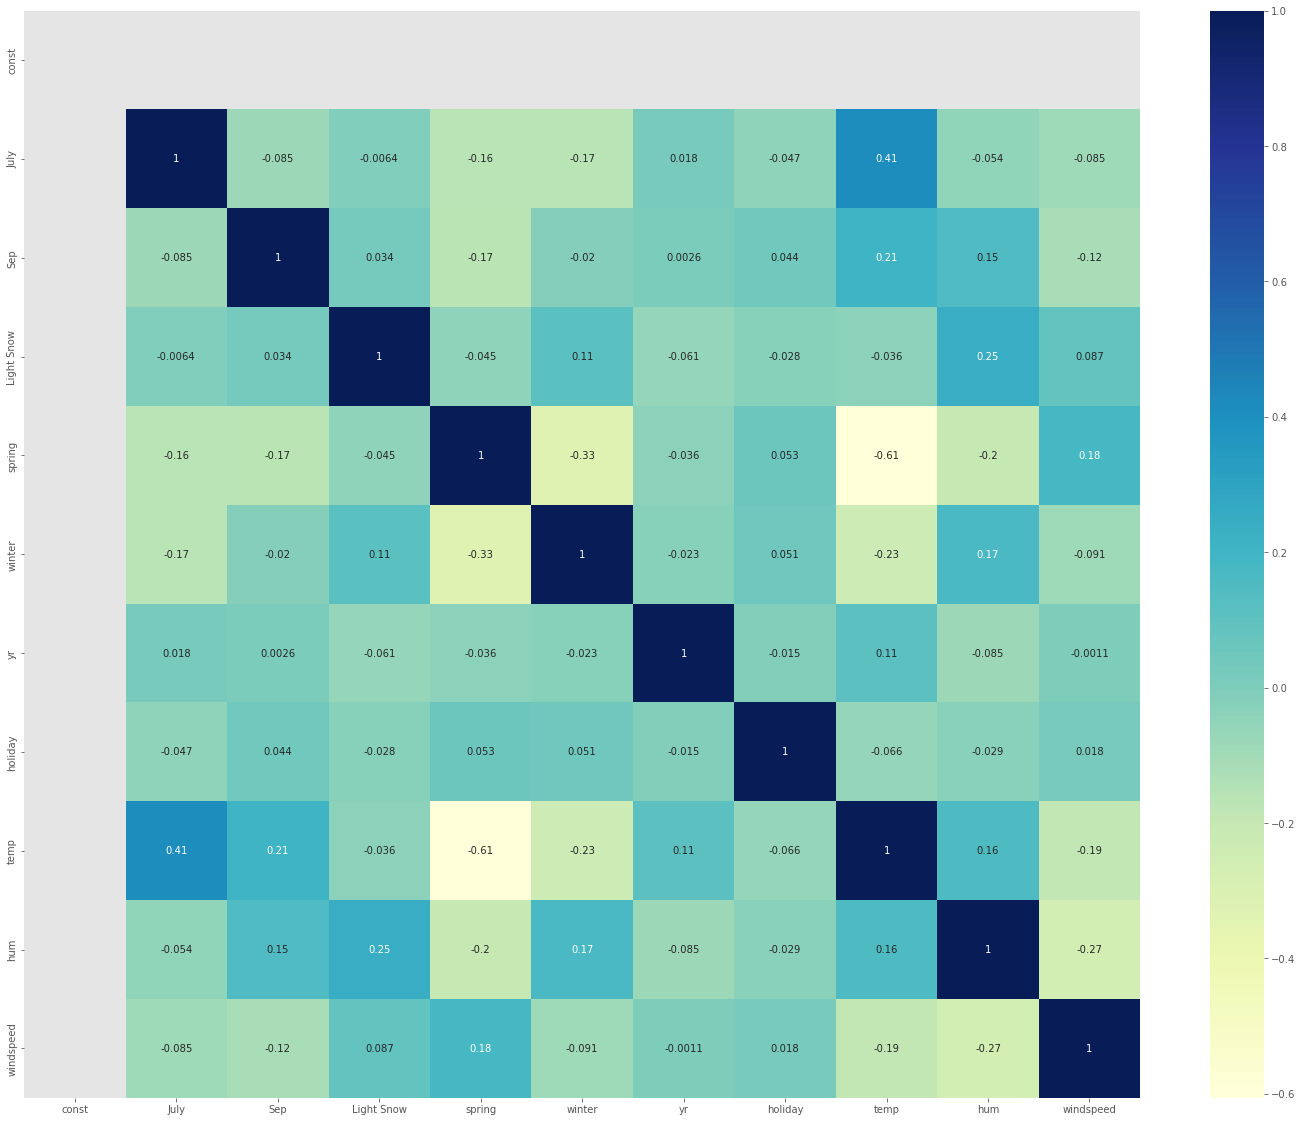

In [120]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (25, 20))
sns.heatmap(X_train_rfe.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [121]:
# Dropping the July variable as it is highly correlated to temprature variable.
X_train_new = X_train_rfe.drop(["July"], axis = 1)

Rebuilding the model without July variable

In [122]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)

#Running the linear model
lm = sm.OLS(y_train,X_train_lm).fit()

##Looking at the summary of our linear model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     257.5
Date:                Mon, 10 Oct 2022   Prob (F-statistic):          2.15e-181
Time:                        17:03:03   Log-Likelihood:                 479.38
No. Observations:                 510   AIC:                            -938.8
Df Residuals:                     500   BIC:                            -896.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3838      0.032     12.132      0.000       0.322       0.446
Sep            0.0728      0.016      4.524      0.000       0.041       0.104
Light Snow    -0.2051      0.026     -7.799      0.000      -0.257      -0.153
spring        -0.1069      0.016     -6.844      0.000      -0.138      -0.076
winter         0.0649      0.013      5.028      0.000       0.040       0.090
yr             0.2299      0.009     26.827      0.000       0.213       0.247
holiday       -0.0904      0.027     -3.345      0.001      -0.143      -0.037
temp           0.4635      0.030     15.681      0.000       0.405       0.522
hum           -0.2547      0.032     -7.886      0.000      -0.318      -0.191
windspeed     -0.1805      0.027     -6.769      0.000      -0.233      -0.128
==============================================================================
Omnibus:                       57.576   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.332
Skew:                          -0.643   Prob(JB):                     1.22e-26
Kurtosis:                       4.991   Cond. No.                         16.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-values of all the predictor variables are significant. 

Checking VIF again

In [123]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,56.00
3,spring,2.51
7,temp,2.49
4,winter,1.75
8,hum,1.24
9,windspeed,1.15
2,Light Snow,1.11
1,Sep,1.07
5,yr,1.03
6,holiday,1.01


From the above model ,we see that the Pvalues of all the 9 variables are very low(approx equal to 0) and VIF values are also less than 3 , which is acceptable.

We will now see the F-Statistic value . F-Statistics F-Statistics is used for testing the overall significance of the Model.

High value for the F-Statistics means the model is more significant and vice-versa.

`F-statistic: **257.5**

`Prob (F-statistic):**2.15e-181**

The F-Statistics value of 257.5 (greater than 1) and the Prob(F-statistic) of '0.000'(very low) states that the overall model is significant.

So we can conclude it as our final model with 9 variables .

Model 2 is our final model with :

R-squared for training set : **0.823 ( 82.3 %)**

Adj R-squared for training set: **0.819 ( 81.9 %)**

R-squared = 82.3 which means that 82.3 % of the variance for the target variable i.e., 'cnt' is explained by the predictor variables , and hence we say that it is a good model.

In [124]:
lm.params

const         0.383769
Sep           0.072829
Light Snow   -0.205113
spring       -0.106869
winter        0.064934
yr            0.229864
holiday      -0.090352
temp          0.463461
hum          -0.254741
windspeed    -0.180547
dtype: float64

In [125]:
round(lm.params,3)

const         0.384
Sep           0.073
Light Snow   -0.205
spring       -0.107
winter        0.065
yr            0.230
holiday      -0.090
temp          0.463
hum          -0.255
windspeed    -0.181
dtype: float64

From the coefficients that we get for the variables, our linear regression equation becomes:

### cnt = 0.384+ 0.073Sep-0.205Light Snow-0.107spring+0.065winter+0.230yr-0.090holiday+0.463temp-0.255hum-0.181windspeed

# Residual Analysis of the training set:

Now we will try to check one of the major assumptions of the linear regression ie.,

>-checking whether the error terms are normally distributed

>-the probability distribution of the error has constant variance

>-the error values are statistically independent

In [126]:
y_train_count = lm.predict(X_train_lm)

In [127]:
res = y_train-y_train_count

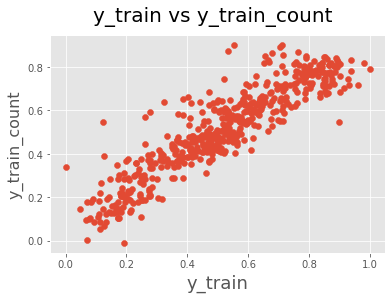

In [128]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_train,y_train_count)

fig.suptitle('y_train vs y_train_count', fontsize=20) 

plt.xlabel('y_train', fontsize=18)                          # X-label
plt.ylabel('y_train_count', fontsize=16)
plt.show()


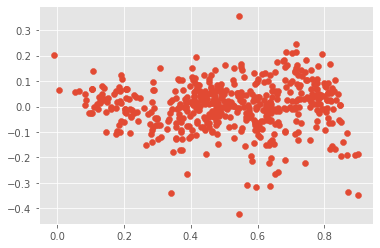

In [129]:
plt.scatter(y_train_count,res)

plt.show()

The probability distribution of the error has constant variance.

Text(0.5, 0, 'Errors')

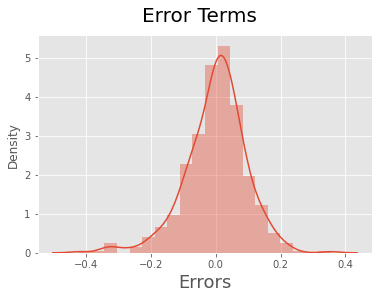

In [130]:
# Plotting the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_count), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                   
plt.xlabel('Errors', fontsize = 18)   

Since the errors terms are normally distributed with mean=0, thus our assumption is satisfied in our model.

# Making Predictions on Test Set:

Applying the scaling on the test set also

In [131]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['temp','hum', 'windspeed','cnt']

bk_test[num_vars] = scaler.fit_transform(bk_test[num_vars])

Dividing into X_test and y_test

In [132]:
y_test = bk_test.pop('cnt')
X_test = bk_test


In [133]:
X_train_new = X_train_new.drop(["const"], axis = 1)

In [134]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

# Making predictions
y_pred = lm.predict(X_test_new)

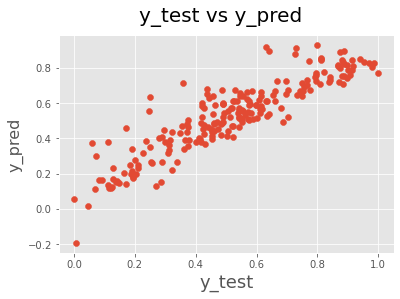

In [135]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20) 

plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # y-label

plt.show()

In [136]:
res=(y_test-y_pred)

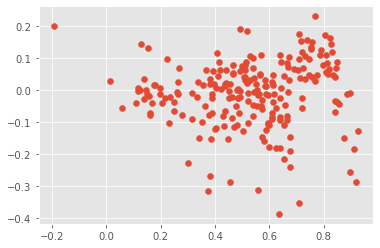

In [137]:
plt.scatter(y_pred,res)

plt.show()

In [138]:
#Calculating R-squared value for Test set
from sklearn.metrics import r2_score

r2=r2_score(y_test, y_pred)
r2

0.8066155308645354

In [139]:
n = X_test_new.shape[0]      # n is number of rows in X_test_new

p = X_test_new.shape[1]     # p= Number of features/predictors which is number of columns in X_test_new

# Calculating Adjusted R-squared value using the formula

adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
adjusted_r2

0.797318200617638

In [140]:
# calculating the Mean Squared Error , Root Mean Squared Error and Mean Absolute error
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.0781356152124461
MSE: 0.010968446879223935
RMSE: 0.10473035318962662


#### R-squared for training set :  82.3 %

#### Adj R-squared for training set:  81.9 %
    
#### R-squared for test set :  80.6 %

#### Adj R-squared for test set: 79.7 %

As we can see that the difference between the R-squared value for the train and test dataset is not more than 5% , therefore we can say that this is a good model.

As we can see that the difference between the Adj R-squared value for the train and test dataset is not more than 5% , therefore we can say that this is a good model .

# Reporting the Final Model

From the coefficients that we get for the variables, our linear regression equation becomes:

#### cnt = 0.384+ 0.073Sep-0.205Light Snow-0.107spring+0.065winter+0.230yr-0.090holiday+0.463temp-0.255hum-0.181windspeed

The three most significant variables affecting the demand for shared bikes are : **temp ,yr and Sep**

